In [21]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import shutil
import cv2


In [3]:
train_dir = "../archive/train"
test_dir = "../archive/test"

In [5]:
labels = os.listdir(train_dir)
labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

* happy, neutral ==> confidence
* fear, sad ==> nervousness

In [12]:
unused_labels = ["angry", "disgust", "surprise"] 
for label in unused_labels:
    train_label_path = os.path.join(train_dir, label)
    test_label_path = os.path.join(test_dir, label)

    if os.path.exists(train_label_path):
        shutil.rmtree(train_label_path)
        print(f"Removed directory: {train_label_path}")
    else:
        print(f"Directory not found, skipping: {train_label_path}")

    if os.path.exists(test_label_path):
        shutil.rmtree(test_label_path)
        print(f"Removed directory: {test_label_path}")
    else:
        print(f"Directory not found, skipping: {test_label_path}")

Removed directory: ../archive/train\angry
Removed directory: ../archive/test\angry
Removed directory: ../archive/train\disgust
Removed directory: ../archive/test\disgust
Removed directory: ../archive/train\surprise
Removed directory: ../archive/test\surprise


In [14]:
labels = os.listdir(train_dir)
print(labels)

['fear', 'happy', 'neutral', 'sad']


In [25]:
# Create new directories for 'nervousness' and 'confidence'
nervousness_dir = os.path.join(train_dir, 'nervousness')
confidence_dir = os.path.join(train_dir, 'confidence')
os.makedirs(nervousness_dir, exist_ok=True)
os.makedirs(confidence_dir, exist_ok=True)

# Move images from 'fear' and 'sad' to 'nervousness'
for label in ['fear', 'sad']:
    src_dir = os.path.join(train_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), nervousness_dir)

# Move images from 'happy' and 'neutral' to 'confidence'
for label in ['happy', 'neutral']:
    src_dir = os.path.join(train_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), confidence_dir)

# Remove the old four folders
for label in labels:
    old_dir = os.path.join(train_dir, label)
    if os.path.exists(old_dir):
        shutil.rmtree(old_dir)

In [26]:
# Create new directories for 'nervousness' and 'confidence'
nervousness_dir = os.path.join(test_dir, 'nervousness')
confidence_dir = os.path.join(test_dir, 'confidence')
os.makedirs(nervousness_dir, exist_ok=True)
os.makedirs(confidence_dir, exist_ok=True)

# Move images from 'fear' and 'sad' to 'nervousness'
for label in ['fear', 'sad']:
    src_dir = os.path.join(test_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), nervousness_dir)

# Move images from 'happy' and 'neutral' to 'confidence'
for label in ['happy', 'neutral']:
    src_dir = os.path.join(test_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), confidence_dir)

# Remove the old four folders
for label in labels:
    old_dir = os.path.join(test_dir, label)
    if os.path.exists(old_dir):
        shutil.rmtree(old_dir)

In [28]:
labels = os.listdir(train_dir)
print(labels)

['confidence', 'nervousness']


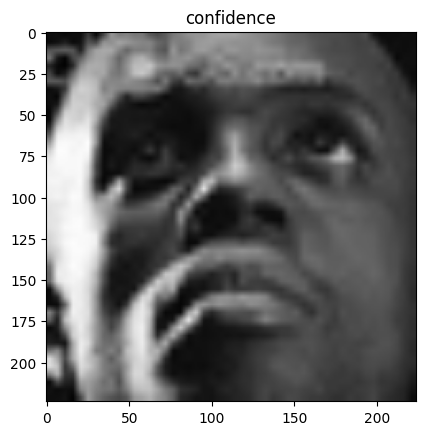

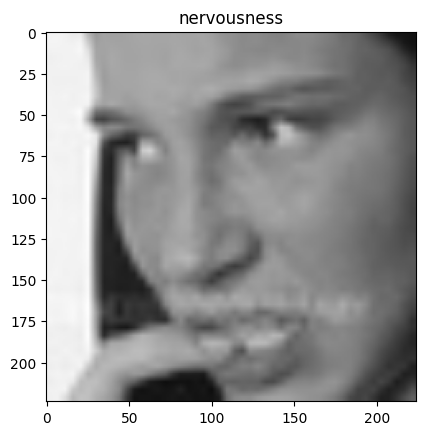

In [29]:
for label in labels:
    imgs = os.listdir(os.path.join(train_dir, label))
    for img in imgs:
        img_path = os.path.join(train_dir, label, img)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        plt.imshow(image)
        plt.title(label)
        plt.show()
        break


In [ ]:
def create_train_data(train_data):
    for label in labels:
        path = os.path.join(train_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                image = cv2.imread(os.path.join(path, img))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                img_array = np.array(image)/255.0
                train_data.append([img_array, class_num])
            except Exception as e:
                pass
                

In [ ]:
train_data = []
create_train_data(train_data)

KeyboardInterrupt: 

In [ ]:
def create_test_data(test_data):
    for label in labels:
        path = os.path.join(test_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                image = cv2.imread(os.path.join(path, img))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                img_array = np.array(image)/255.0
                train_data.append([img_array, class_num])
            except Exception as e:
                pass
                

In [ ]:
test_data = []
create_test_data(test_data)

In [30]:
print(len(train_data))
print(len(test_data))

0


NameError: name 'test_data' is not defined

In [ ]:
import random 
random.shuffle(train_data)
random.shuffle(test_data)